# SVD and PCA

This notebook performs a careful **SVD–PCA analysis** of the *Telecom Traffic* dataset.  
The goals are:

- Build a clean feature matrix from the variables: `Season`, `DayOfWeek`, `Period`,
  `PricePerGB`, `Arrivals`, `Departures`.
- Standardize the data so that all features are on the same scale.
- Use **SVD** of the data matrix to obtain the **principal components** (PCA).
- Decide what variables are most important and what are less and can be dropped.
- Prepare a PCA-based feature set that can later be used by a forecasting model


In [86]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt


#load the data
data_path = "Telecom Traffic Data MATH 557.csv"
df = pd.read_csv(data_path)


print("rows, cols:", df.shape)
df.head()


rows, cols: (500, 6)


,Season,DayOfWeek,Period,PricePerGB,Arrivals,Departures
0,3,7,5,2,33,24
1,4,5,21,2,33,35
2,1,5,5,1,45,54
3,3,7,10,1,63,44
4,3,1,10,2,33,21


In [87]:
df.describe()


,Season,DayOfWeek,Period,PricePerGB,Arrivals,Departures
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.592000,3.956000,12.354000,1.470000,40.778000,38.126000
std,1.150732,2.000517,7.033037,0.499599,11.239991,11.435194
min,1.000000,1.000000,1.000000,1.000000,19.000000,16.000000
25%,2.000000,2.000000,6.000000,1.000000,31.000000,28.000000
50%,3.000000,4.000000,12.000000,1.000000,40.500000,38.000000
75%,4.000000,6.000000,19.000000,2.000000,50.000000,48.000000
max,4.000000,7.000000,24.000000,2.000000,72.000000,69.000000


In [90]:
# Correlation matrix between all numeric variables
corr = df.corr(numeric_only=True)
corr


,Season,DayOfWeek,Period,PricePerGB,Arrivals,Departures
Season,1.000000,-0.026965,0.027044,0.023982,0.002589,-0.000959
DayOfWeek,-0.026965,1.000000,-0.031651,-0.097568,0.052593,0.115001
Period,0.027044,-0.031651,1.000000,-0.007523,-0.000145,-0.047701
PricePerGB,0.023982,-0.097568,-0.007523,1.000000,-0.837874,-0.847698
Arrivals,0.002589,0.052593,-0.000145,-0.837874,1.000000,0.719520
Departures,-0.000959,0.115001,-0.047701,-0.847698,0.719520,1.000000


In [92]:
# Correlation of each explanatory variable with the targets
predictors = ["Season", "DayOfWeek", "Period", "PricePerGB"]
targets = ["Arrivals", "Departures"]

corr_targets = corr.loc[predictors, targets]
corr_targets


,Arrivals,Departures
Season,0.002589,-0.000959
DayOfWeek,0.052593,0.115001
Period,-0.000145,-0.047701
PricePerGB,-0.837874,-0.847698


From the correlation table we observe:

- `PricePerGB` have a negative correlation with `Arrivals` and `Departures` (about −0.84), thats means that lower prices are associated with much higher traffic.
- `DayOfWeek` and `Period` have only weak correlations with the targets
- `Season` is essentially uncorrelated with `Arrivals` and `Departures` (correlation values very close to zero).

From this only we can assume that `PricePerGB` is by far the most important feature for forecasting, while `DayOfWeek` and `Period` provide only minor adjustments, especially `Season`  

So, for the **PCA** we will still keep all six variables, but for the forecasting features we will later drop `Season`

## 2. Building and standardizing the data matrix


To make PCA meaningful, each column is:
1. **Centered** by subtracting its sample mean.
2. **Standardized** by dividing by its sample standard deviation.

This prevents variables with large numerical variance (for example, `Period` or `Arrivals`)
from dominating the principal components.

In [104]:

feature_names = ["Season", "DayOfWeek", "Period","PricePerGB", "Arrivals", "Departures"]
X = df[feature_names].to_numpy(dtype=float)

n_samples, n_features = X.shape

print("Number of samples:", n_samples)
print("Number of features:", n_features)

# Columns: means and standard deviations
mean_vec = X.mean(axis=0)
std_vec = X.std(axis=0, ddof=0)

print("\nFeature means:")
for name, m in zip(feature_names, mean_vec):
    print(f"{name:}: {m}")

print("\nFeature standard deviations:")
for name, s in zip(feature_names, std_vec):
    print(f"{name:}: {s}")

# Standardize: (X - mean) / std
X_std = (X - mean_vec) / std_vec


Number of samples: 500
Number of features: 6

Feature means:
Season: 2.592
DayOfWeek: 3.956
Period: 12.354
PricePerGB: 1.47
Arrivals: 40.778
Departures: 38.126

Feature standard deviations:
Season: 1.1495807931589672
DayOfWeek: 1.9985154490271022
Period: 7.026000569313954
PricePerGB: 0.49909918853871116
Arrivals: 11.228745076810677
Departures: 11.42375262337206


## 3. SVD and PCA of the standardized data

For PCA we form the matrix
\[
B = X_{\text{std}}^\top X_{\text{std}} \in \mathbb{R}^{6\times 6},
\]
which is symmetric and positive semi-definite.  

If \(\lambda_i\) and \(v_i\) are the eigenvalues and eigenvectors of \(B\), then

- \(\sigma_i = \sqrt{\lambda_i}\) are the **singular values** of \(X_{\text{std}}\),
- the columns of \(V = [v_1,\dots,v_6]\) are the **right singular vectors**, and
- the **left singular vectors** are
  \[
  u_i = \frac{1}{\sigma_i} X_{\text{std}}\, v_i.
  \]

The eigenvalues are proportional to the variance explained by each principal component.

In [112]:
B = X_std.T @ X_std

eigvals_B, V = LA.eigh(B)  # eigenvalues in ascending order
idx =np.argsort(eigvals_B)[::-1]
eigvals =eigvals_B[idx]
V = V[:, idx]

print("Eigenvalues of B (lambda_i):")
print(eigvals)

# Singular values
singular_vals = np.sqrt(eigvals)
print("\nSingular values (sigma_i):")
print(singular_vals)

# Left singular vectors U from X_std and V
U = np.zeros((n_samples, n_features))
for i in range(n_features):
    if singular_vals[i] > 1e-12:
        U[:, i] = (X_std @ V[:, i]) / singular_vals[i]

S = np.diag(singular_vals)

# Check reconstruction
X_reconstructed = U @ S @ V.T

fro_error = LA.norm(X_std - X_reconstructed)
print(f"\nFrobenius norm = {fro_error}")


Eigenvalues of B (lambda_i):
[1309.93370504  526.28473974  487.67779504  481.18972971  138.31122267
   56.6028078 ]

Singular values (sigma_i):
[36.1930063  22.94089666 22.08342806 21.93603724 11.76057918  7.52348375]

Frobenius norm = 2.4807492629056323e-14


PC1: eigenvalue = 1309.9337050416384, explained variance = 43.66445683472129%
PC2: eigenvalue = 526.284739742559, explained variance = 17.54282465808531%
PC3: eigenvalue = 487.6777950411799, explained variance = 16.255926501372667%
PC4: eigenvalue = 481.1897297053223, explained variance = 16.03965765684408%
PC5: eigenvalue = 138.31122266688197, explained variance = 4.610374088896068%
PC6: eigenvalue = 56.602807802418035, explained variance = 1.8867602600806017%


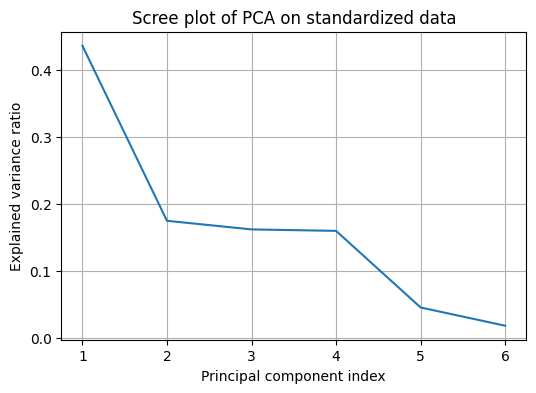

In [120]:
total_lambda = eigvals.sum()

explained_variance_ratio = eigvals / total_lambda

for i, (lam, ratio) in enumerate(zip(eigvals, explained_variance_ratio), start=1):
    print(f"PC{i}: eigenvalue = {lam}, "
          f"explained variance = {100*ratio:}%")

plt.figure()

plt.plot(range(1, n_features + 1), explained_variance_ratio)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot of PCA on standardized data")
plt.xticks(range(1, n_features + 1))

plt.show()


### 3.2 Loadings — contribution of each feature to each PC


In [122]:
loadings = pd.DataFrame(V,index=feature_names, columns=[f"PC{i}" for i in range(1, n_features + 1)])

loadings


,PC1,PC2,PC3,PC4,PC5,PC6
Season,-0.010071,-0.574808,0.790413,0.210256,0.000743,-0.023103
DayOfWeek,0.094786,0.525282,0.163350,0.827511,-0.059867,0.007265
Period,-0.016028,-0.621190,-0.588056,0.515018,0.042374,0.031888
PricePerGB,-0.593626,0.039792,0.037957,0.025872,-0.032266,0.801794
Arrivals,0.562231,-0.078722,-0.020348,-0.065916,-0.719348,0.394309
Departures,0.567593,0.004134,0.029995,-0.027566,0.690013,0.447262


From the loadings matrix we observe:

- **PC1** has large loadings for `PricePerGB` (with opposite sign) and for the traffic variables `Arrivals` and `Departures`
- **PC2** and **PC3** are related to the date variables `Season`, `DayOfWeek`, `Period`. They describe more subtle seasonal and time of the day patterns.
- The last two components explain only a small fraction of the variance.

Overall, p1, pc2, pc3, pc4 already capture more than 95 % of the total variance, So its more reasonable to reduce the dimensional data to a 2–4 dimensional PCA.

### 3.3 PCA scores and visualization

We will look at the first two components and color the points by `PricePerGB` to visualize how price levels effecting the traffic pattern

In [123]:
# Project onto the first k principal components
k = 2
V_k = V[:, :k]
Z = X_std @ V_k



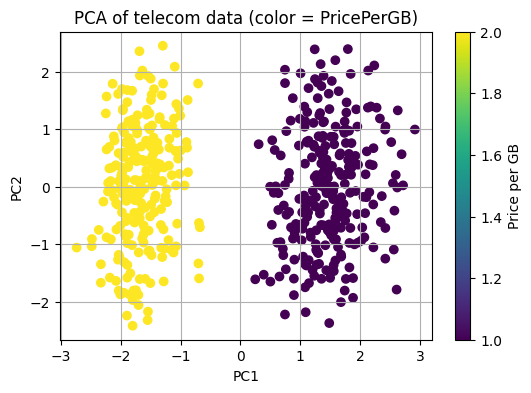

In [130]:
plt.figure()
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=df["PricePerGB"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of telecom data (color = PricePerGB)")
plt.colorbar(scatter, label="Price per GB")
plt.show()


## 4. PCA-based features for forecasting

For forecasting, the targets are `Arrivals` and `Departures`, So we will not include the targets themselves in the PCA used for the model
inputs.

and we will drop `Season` because:

- it is almost not correlated with the targets (correlations near to zero), meaning its not very meaningful for a linear model without one-hot encoding.

We standardize these three predictors, compute their PCA, and keep the first few principal components as compact features to hand off to next step to build the forecasting models.

In [131]:

predictor_names = ["DayOfWeek", "Period", "PricePerGB"]
X_pred = df[predictor_names].to_numpy(dtype=float)

# Standardize predictors
pred_mean = X_pred.mean(axis=0)
pred_std = X_pred.std(axis=0, ddof=0)
X_pred_std = (X_pred - pred_mean) / pred_std


B_pred = X_pred_std.T @ X_pred_std
eigvals_pred, V_pred = LA.eigh(B_pred)
idx_pred = np.argsort(eigvals_pred)[::-1]
eigvals_pred = eigvals_pred[idx_pred]
V_pred = V_pred[:, idx_pred]

explained_var_pred = eigvals_pred / eigvals_pred.sum()

print("Eigenvalues for predictor PCA:", eigvals_pred)
print("Explained variance ratios:", explained_var_pred)

# Choose k predictive PCs (here k = 2 captures about 70% of the predictor variance)
k_pred = 2
V_pred_k = V_pred[:, :k_pred]
Z_pred = X_pred_std @ V_pred_k   # PCA scores used as forecasting features

print("\nShape of Z_pred (PCA predictor scores):", Z_pred.shape)
Z_pred[:5]


Eigenvalues for predictor PCA: [550.28898928 502.20022121 447.5107895 ]
Explained variance ratios: [0.36685933 0.33480015 0.29834053]

Shape of Z_pred (PCA predictor scores): (500, 2)


array([[ 0.54725298,  1.40978624],
       [-0.56212282, -0.81382944],
       [ 1.19381507,  0.73796926],
       [ 1.78405869,  0.12122643],
       [-1.71788947,  0.55491139]])

In [132]:
# Combine PCA features with targets and save for the forecasting teammate
pca_feature_cols = [f"PC_pred_{i+1}" for i in range(Z_pred.shape[1])]
df_pca_features = pd.DataFrame(Z_pred, columns=pca_feature_cols)
df_pca_features["Arrivals"] = df["Arrivals"].to_numpy()
df_pca_features["Departures"] = df["Departures"].to_numpy()

df_pca_features.head()


,PC_pred_1,PC_pred_2,Arrivals,Departures
0,0.547253,1.409786,33,24
1,-0.562123,-0.813829,33,35
2,1.193815,0.737969,45,54
3,1.784059,0.121226,63,44
4,-1.717889,0.554911,33,21


In [133]:
output_csv = "Transformed_PCA_Data.csv"
df_pca_features.to_csv(output_csv, index=False)
output_csv


'Transformed_PCA_Data.csv'

What next?

The file `Transformed_PCA_Data.csv` contains:

- the first two PCA scores based on `DayOfWeek`, `Period`, and `PricePerGB`, and the original targets `Arrivals` and `Departures`.

- We can use `PC_pred_1` and `PC_pred_2` as the main inputs in upcomming pred. methods such as linear regression, time-series, or neural network models.
- The PCA transform itself is defined by the vectors `pred_mean`, `pred_std`, and `V_pred_k`, For any new future day we can compute the predictors, standardize them, apply the same PCA transform.

### 5. Summary of PCA decisions

- We standardized all six variables and used SVD of the standardized matrix to obtain the PCA.
- The first principal component catch the price vs traffic pattern.
- The next components catch weaker seasonal and time of day structure.
- For forecasting we avoid using the targets inside PCA and instead run a separate PCA on the explanatory variables (`DayOfWeek`, `Period`, `PricePerGB`), after dropping `Season` which adds almost no linear information about arrivals or departures.
- The resulting PCA scores provide a well-conditioned set of features (roughly orthogonal and scaled) that are convenient inputs for the later forecasting algorithms in the project.
